In [2]:
!pip install tensorflow==2.12.0
!pip install ampligraph

In [3]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf

In [4]:
!pip install rdflib
!pip install PyDrive

In [5]:
from rdflib import URIRef, BNode, Literal, Namespace, Graph
from rdflib.namespace import Namespace, NamespaceManager
from rdflib.plugins import sparql
from rdflib.namespace import RDF, RDFS, XSD
from rdflib.serializer import Serializer
from google.colab import drive

drive.mount('/content/drive')

def extract_local_name(uri):
    if "#" in uri:
        return uri.split("#")[-1]
    elif "/" in uri:
        return uri.split("/")[-1]
    return uri

def load_triplets(g):
    triplets = []
    for subj, pred, obj in g:
        triplets.append((
            extract_local_name(str(subj)),
            extract_local_name(str(pred)),
            extract_local_name(str(obj))))

    triplets_df = pd.DataFrame(triplets, columns=["subject", "predicate", "object"])
    triplets_df.dropna(inplace=True)
    return triplets_df

g = Graph()
g.parse("/content/drive/MyDrive/Ontology_dnd.owl", format="xml")
triplets_df = load_triplets(g)
triplets = triplets_df.to_numpy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_test = train_test_split_no_unseen(triplets, test_size=0.2)

In [7]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (6487, 3)
Test set size:  (1621, 3)


In [8]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

model = ScoringBasedEmbeddingModel(k=100,
                                   eta=20,
                                   scoring_type='ComplEx',
                                   seed=0)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

In [9]:
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 50),
          epochs=300,
          verbose=True
          )

Epoch 1/300
52/52 [==============================] - 12s 227ms/step - loss: 387.2613
Epoch 2/300
52/52 [==============================] - 3s 61ms/step - loss: 387.2378
Epoch 3/300
52/52 [==============================] - 3s 58ms/step - loss: 387.2167
Epoch 4/300
52/52 [==============================] - 3s 51ms/step - loss: 387.1961
Epoch 5/300
52/52 [==============================] - 3s 63ms/step - loss: 387.1755
Epoch 6/300
52/52 [==============================] - 2s 48ms/step - loss: 387.1539
Epoch 7/300
52/52 [==============================] - 3s 50ms/step - loss: 387.1319
Epoch 8/300
52/52 [==============================] - 3s 65ms/step - loss: 387.1092
Epoch 9/300
52/52 [==============================] - 4s 68ms/step - loss: 387.0860
Epoch 10/300
52/52 [==============================] - 3s 59ms/step - loss: 387.0619
Epoch 11/300
52/52 [==============================] - 2s 41ms/step - loss: 387.0374
Epoch 12/300
52/52 [==============================] - 3s 51ms/step - loss: 387.0116

In [10]:
ranks = model.evaluate(X_test, use_filter={'train': X_train, 'test': X_test}, corrupt_side='s,o', verbose=True)

164/164 [==============================] - 7s 45ms/step


In [11]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.33
MR: 93.20
Hits@10: 0.52
Hits@3: 0.36
Hits@1: 0.23


In [12]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

fatal: destination path 'incf.countryutils' already exists and is not an empty directory.
Processing /content/incf.countryutils
  Preparing metadata (setup.py) ... done
  Created wheel for incf.countryutils: filename=incf.countryutils-1.2-py3-none-any.whl size=21366 sha256=d2bb347f1f89109a31cdf3ff350686eb9d05d53aa5c4573e6987ec098529d67f
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ouod43p/wheels/c5/6d/14/97b9e81573cddb65059b909bb41583ef4b24011da29aac7d7e
Successfully built incf.countryutils
  Attempting uninstall: incf.countryutils
    Found existing installation: incf.countryutils 1.2
    Uninstalling incf.countryutils-1.2:
      Successfully uninstalled incf.countryutils-1.2


In [13]:
!pip install adjustText

In [14]:
# Список для хранения данных
data = []

# Извлечение всех индивидов (монстров)
monsters = set(g.subjects(predicate=None, object=None))

# Извлечение атрибутов для каждого индивида
for monster in monsters:
    if isinstance(monster, URIRef):  # Проверяем, что это индивид (не литерал)
        monster_name = monster.split("#")[-1]  # Извлекаем имя индивида
        attributes = {}

        # Извлечение всех предикатов и объектов для индивида
        for predicate, obj in g.predicate_objects(monster):
            if isinstance(obj, Literal):  # Если объект — литерал (строка, число и т.д.)
                attributes[predicate.split("#")[-1]] = obj.toPython()
            elif isinstance(obj, URIRef):  # Если объект — другой индивид
                attributes[predicate.split("#")[-1]] = obj.split("#")[-1]

        # Добавляем данные в список
        data.append({"name": monster_name, **attributes})

# Преобразование в DataFrame
df = pd.DataFrame(data)

# Список числовых столбцов
numeric_columns = [
    'hasArmor', 'hasHp', 'hasStr', 'hasCon', 'hasInt', 'hasWis', 'hasCha'
]

# Преобразование в числовой формат
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Заполнение пропущенных значений средними
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Список категориальных столбцов
categorical_columns = [
    'hasLocation', 'hasSize', 'hasType', 'hasWorldview',
    'hasResistanceToDamage', 'hasImmunityToDamage', 'hasImmunityToState',
    'comment', 'hasLanguage', 'domain', 'range', 'hasVulnerabilityToDamage',
    'hasRankEx', 'inverseOf', 'hasExtraStates', 'hasSizeCell'
]

# Заполнение пропущенных значений
df[categorical_columns] = df[categorical_columns].fillna('Unknown')

# Преобразование столбца hasRank
def convert_rank(value):
    try:
        # Если значение является дробью (например, "1/8"), преобразуем его в число
        if '/' in str(value):
            numerator, denominator = map(float, str(value).split('/'))
            return numerator / denominator
        # Если значение является числом, возвращаем его
        return float(value)
    except (ValueError, TypeError):
        # Если преобразование невозможно, возвращаем NaN
        return np.nan

# Применение функции к столбцу hasRank
df['hasRank'] = df['hasRank'].apply(convert_rank)

# Заполнение пропущенных значений средним
df['hasRank'] = df['hasRank'].fillna(df['hasRank'].mean())

print(df.head())

                                        name   type hasLocation   hasSize  \
0                Черный_Пудинг_Black_Pudding  Enemy       Холмы   Большой   
1                               Охряное_желе  Enemy       Холмы   Большой   
2  Взрослый_Черный_Дракон_Adult_Black_Dragon  Enemy       Холмы  Огромный   
3          Гигантский_горностай_Giant_Weasel  Enemy        Горы   Средний   
4                            Скелет_Skeleton  Enemy       Город   Средний   

  hasType  hasRank hasImmunityToDamage hasImmunityToState  \
0   Слизь    4.000             Рубящий       Сбитый_с_ног   
1   Слизь    2.000             Рубящий       Сбитый_с_ног   
2  Дракон   14.000           Кислотный            Unknown   
3   Зверь    0.125             Unknown            Unknown   
4  Нежить    0.250             Unknown        Отравленный   

           hasWorldview  hasArmor  ...  hasResistanceToDamage  \
0   Истинно_нейтральный       7.0  ...                Unknown   
1   Истинно_нейтральный       8.0  ...  


1 triples containing invalid keys skipped! You can use `ScoringBasedEmbeddingModel.get_invalid_keys` or`DataIndexer.get_invalid_keys` to find out which keys are invalid.



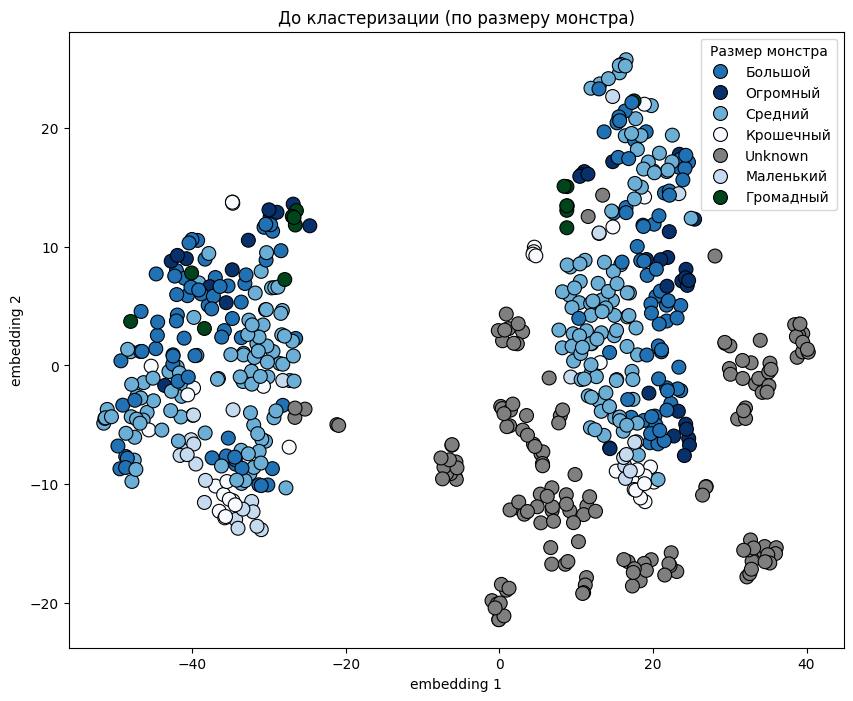

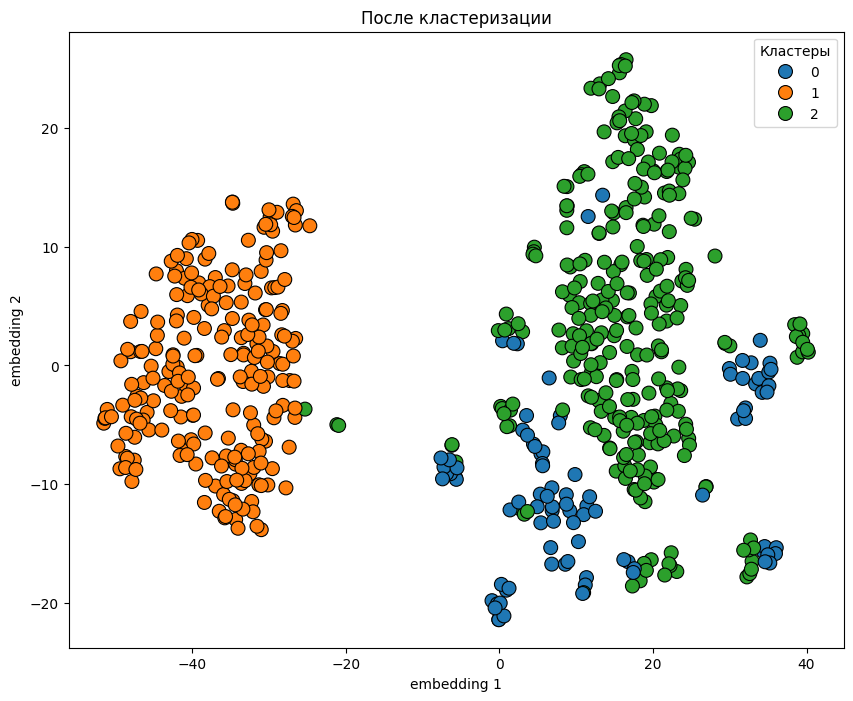

In [15]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Шаг 1: Получение списка сущностей
monster_entities = df['name'].tolist()

# Шаг 2: Поиск пропущенных сущностей
invalid_keys = []
valid_embeddings = []

for entity in monster_entities:
    try:
        embedding = model.get_embeddings([entity])
        valid_embeddings.append(embedding[0])  # Сохраняем эмбеддинг
    except Exception as e:
        invalid_keys.append(entity)  # Записываем сущность, которая вызвала ошибку

# print("Пропущенные сущности:", invalid_keys)

# Шаг 3: Удаление пропущенных сущностей из DataFrame
df = df[~df['name'].isin(invalid_keys)]

# Шаг 4: Повторное получение эмбеддингов (теперь все сущности должны быть валидными)
monster_entities = df['name'].tolist()

try:
    monsters_embeddings = np.array([model.get_embeddings([entity])[0] for entity in monster_entities])
except Exception as e:
    print(f"Ошибка генерации эмбеддингов: {e}")
    exit()

# Шаг 5: Масштабирование данных
scaler = StandardScaler()
monsters_embeddings_scaled = scaler.fit_transform(monsters_embeddings)

# Шаг 6: Уменьшение размерности с помощью PCA
pca = PCA(n_components=50)
monsters_embeddings_pca = pca.fit_transform(monsters_embeddings_scaled)

# Шаг 7: Визуализация до кластеризации с помощью t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_embeddings_before = tsne.fit_transform(monsters_embeddings_pca)

# Создаем палитру для размеров, где цвета идут по нарастающей
size_palette = {
    'Крошечный': '#f7fbff',  # Очень светлый синий
    'Маленький': '#c6dbef',  # Светлый синий
    'Средний': '#6baed6',    # Средний синий
    'Большой': '#2171b5',    # Темный синий
    'Огромный': '#08306b',   # Очень темный синий
    'Громадный': '#00441b',  # Темно-зеленый
    'Unknown': '#7f7f7f'     # Серый (для Unknown)
}

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_embeddings_before[:, 0],
    y=reduced_embeddings_before[:, 1],
    hue=df['hasSize'].fillna('Unknown'),  # Заменяем NaN на 'Unknown'
    palette=size_palette,  # Используем нашу палитру
    s=100,
    edgecolor='black'
)
plt.title('До кластеризации (по размеру монстра)')
plt.xlabel('embedding 1')
plt.ylabel('embedding 2')
plt.legend(title='Размер монстра')
plt.show()

# Шаг 8: Кластеризация с использованием KMeans (3 кластера)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
predicted_labels = kmeans.fit_predict(monsters_embeddings_pca)

# Шаг 9: Добавление меток кластеров в DataFrame
df['cluster'] = predicted_labels

# Шаг 10: Визуализация после кластеризации
reduced_embeddings_after = tsne.fit_transform(monsters_embeddings_pca)

# Создаем палитру для кластеров (3 цвета)
cluster_palette = {
    0: '#1f77b4',  # Синий
    1: '#ff7f0e',  # Оранжевый
    2: '#2ca02c',  # Зеленый
}

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_embeddings_after[:, 0],
    y=reduced_embeddings_after[:, 1],
    hue=df['cluster'],  # Используем метки кластеров для окраски точек
    palette=cluster_palette,  # Используем нашу палитру
    s=100,
    edgecolor='black'
)
plt.title('После кластеризации')
plt.xlabel('embedding 1')
plt.ylabel('embedding 2')
plt.legend(title='Кластеры')
plt.show()

# Шаг 11: Оценка качества кластеризации (если есть истинные метки)
if 'hasSize' in df.columns:
    # Преобразование hasSize в числовые метки
    size_mapping = {
        'Крошечный': 0,
        'Маленький': 1,
        'Средний': 2,
        'Большой': 3,
        'Огромный': 4,
        'Громадный': 5,
        'Unknown': -1  # Добавляем Unknown
    }
    true_labels = df['hasSize'].fillna('Unknown').map(size_mapping).values

    # Проверка на NaN в true_labels
    if np.isnan(true_labels).any():
        true_labels = np.nan_to_num(true_labels, nan=-1)

    # Проверка на NaN в predicted_labels
    if np.isnan(predicted_labels).any():
        print("Обнаружены NaN в predicted_labels. Проверьте данные и модель.")
    else:
        # Вычисление Adjusted Rand Score
        ari = adjusted_rand_score(true_labels, predicted_labels)
        # print(f"Adjusted Rand Score: {ari:.2f}")

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.dummy import DummyClassifier

# Шаг 1: Загрузка данных и получение эмбеддингов

# Извлечение эмбеддингов для всех сущностей
monster_entities = df['name'].tolist()
try:
    monsters_embeddings = np.array([model.get_embeddings([entity])[0] for entity in monster_entities])
except Exception as e:
    print(f"Ошибка генерации эмбеддингов: {e}")
    exit()

# Создание DataFrame с эмбеддингами и целевым признаком
data = pd.DataFrame(monsters_embeddings)
data['hasType'] = df['hasType'].fillna('Unknown')  # Заполняем пропущенные значения

# Шаг 2: Разделение данных на обучающую и тестовую выборки
X = data.drop(columns=['hasType'])  # Признаки (эмбеддинги)
y = data['hasType']  # Целевой признак (тип монстра)

# Преобразуем текстовые метки в числовые
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Шаг 3: Обучение модели XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss')  # Убрали use_label_encoder
xgb_model.fit(X_train, y_train)

# Шаг 4: Оценка точности модели XGBoost
y_pred = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred)
print(f"Точность XGBoost: {accuracy_xgb:.2f}")

# Шаг 5: Базовая модель 1 — всегда предсказывает наиболее частый класс
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
print(f"Точность базовой модели (наиболее частый класс): {accuracy_dummy:.2f}")

# Шаг 6: Базовая модель 2 — one-hot-encoding вместо эмбеддингов
# Создаем one-hot-encoding для имен монстров
one_hot_encoder = OneHotEncoder(sparse_output=False)  # Используем sparse_output вместо sparse
X_one_hot = one_hot_encoder.fit_transform(df[['name']])

# Разделение данных
X_train_one_hot, X_test_one_hot, y_train_one_hot, y_test_one_hot = train_test_split(
    X_one_hot, y_encoded, test_size=0.2, random_state=42
)

# Обучение XGBoost на one-hot-encoding
xgb_model_one_hot = XGBClassifier(random_state=42, eval_metric='mlogloss')  # Убрали use_label_encoder
xgb_model_one_hot.fit(X_train_one_hot, y_train_one_hot)

# Оценка точности
y_pred_one_hot = xgb_model_one_hot.predict(X_test_one_hot)
accuracy_one_hot = accuracy_score(y_test_one_hot, y_pred_one_hot)
print(f"Точность XGBoost с one-hot-encoding: {accuracy_one_hot:.2f}")

# Шаг 7: Выводы
print("\nСравнение точности моделей:")
print(f"- XGBoost с эмбеддингами: {accuracy_xgb:.2f}")
print(f"- Базовая модель (наиболее частый класс): {accuracy_dummy:.2f}")
print(f"- XGBoost с one-hot-encoding: {accuracy_one_hot:.2f}")

if accuracy_xgb > accuracy_dummy and accuracy_xgb > accuracy_one_hot:
    print("\nВывод: Использование эмбеддингов улучшило точность классификации.")
else:
    print("\nВывод: Использование эмбеддингов не улучшило точность классификации.")

Точность XGBoost: 0.64
Точность базовой модели (наиболее частый класс): 0.24
Точность XGBoost с one-hot-encoding: 0.24

Сравнение точности моделей:
- XGBoost с эмбеддингами: 0.64
- Базовая модель (наиболее частый класс): 0.24
- XGBoost с one-hot-encoding: 0.24

Вывод: Использование эмбеддингов улучшило точность классификации.


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.special import expit
from ampligraph.datasets import load_from_csv
from ampligraph.latent_features import ScoringBasedEmbeddingModel  # Используем новый класс
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features.loss_functions import NLLLoss  # Функция потерь
from tensorflow.keras.optimizers import Adam  # Оптимизатор из TensorFlow/Keras

# Преобразование данных в массив
triples = np.array(triplets)

# Разделение на тренировочную и тестовую выборки
X_train, X_valid = train_test_split(triples, test_size=0.2, random_state=42)

# Преобразование данных в DataFrame
df = pd.DataFrame(X_train, columns=['subject', 'predicate', 'object'])

# Выбор монстра для анализа
target_monster = "Гоблин_Goblin"
print("Все атрибуты монстра:")
print(df[df['subject'] == target_monster])

# Фильтрация данных (удаляем некоторые атрибуты)
filtered_data = df[
    (df['subject'] != target_monster) |
    ((df['subject'] == target_monster) & ~df['predicate'].isin(["hasHP", "hasAttack"]))
]

# Конвертация отфильтрованных данных обратно в массив
df_filtered = np.array(filtered_data)

# Инициализация модели
model = ScoringBasedEmbeddingModel(
    k=50,  # Размерность embedding
    eta=5,  # Количество негативных примеров
    scoring_type="ComplEx",  # Используем ComplEx в качестве scoring function
    seed=42,
)

# Компиляция модели
optimizer = Adam(learning_rate=0.001)  # Оптимизатор из TensorFlow/Keras
loss = NLLLoss()  # Функция потерь
model.compile(optimizer=optimizer, loss=loss)

# Обучение модели на отфильтрованных данных
model.fit(df_filtered, epochs=1000)

# Проверка на недопустимые ключи
invalid_subjects, invalid_predicates, invalid_objects = model.get_invalid_keys(df_filtered)
invalid_keys = set(invalid_subjects + invalid_predicates + invalid_objects)

if invalid_keys:
    print("Недопустимые ключи в обучающих данных:", invalid_keys)
    # Удаляем триплеты с недопустимыми ключами
    df_filtered = np.array([triplet for triplet in df_filtered if not any(key in triplet for key in invalid_keys)])

# Формирование утверждений для предсказания
statements = np.array([
    [target_monster, 'hasArmor', '15'],
    [target_monster, 'hasType', 'Гуманоид'],
    [target_monster, 'hasSize', 'Маленький'],
    [target_monster, 'hasLanguage', 'Гоблинский'],
    [target_monster, 'hasLocation', 'Равнина/луг'],
    [target_monster, 'hasSize', 'Громадный'],
    [target_monster, 'hasLanguage', 'Драконий'],
])

# Проверка на недопустимые ключи в утверждениях
invalid_subjects_statements, invalid_predicates_statements, invalid_objects_statements = model.get_invalid_keys(statements)
invalid_keys_statements = set(invalid_subjects_statements + invalid_predicates_statements + invalid_objects_statements)

if invalid_keys_statements:
    print("Недопустимые ключи в утверждениях:", invalid_keys_statements)
    # Удаляем утверждения с недопустимыми ключами
    statements = np.array([stmt for stmt in statements if not any(key in stmt for key in invalid_keys_statements)])

# Предсказание вероятностей
scores = model.predict(statements)
probs = expit(scores)

# Преобразование результатов в DataFrame
result_df = pd.DataFrame(list(zip([' '.join(map(str, x)) for x in statements],
                                  scores,
                                  probs)),
                         columns=['statement', 'score', 'prob']).sort_values("prob", ascending=False)

print("\nПредсказанные атрибуты:")
print(result_df)


Все атрибуты монстра:
            subject     predicate            object
316   Гоблин_Goblin          type   NamedIndividual
346   Гоблин_Goblin        hasWis                 8
1069  Гоблин_Goblin   hasLanguage        Гоблинский
1116  Гоблин_Goblin        hasInt                10
1267  Гоблин_Goblin  hasWorldview  Нейтральный_злой
2541  Гоблин_Goblin   hasLocation       Равнина/луг
3928  Гоблин_Goblin       hasRank               1/4
4166  Гоблин_Goblin          type             Enemy
4909  Гоблин_Goblin        hasStr                 8
5292  Гоблин_Goblin       hasSize         Маленький
6440  Гоблин_Goblin      hasArmor                15
Epoch 1/1000
8/8 [==============================] - 4s 551ms/step - loss: 6422.5737
Epoch 2/1000
8/8 [==============================] - 1s 66ms/step - loss: 6421.4492
Epoch 3/1000
8/8 [==============================] - 1s 73ms/step - loss: 6420.4546
Epoch 4/1000
8/8 [==============================] - 0s 61ms/step - loss: 6419.4604
Epoch 5/1000
8/8 [===